In [1]:
# Imports for the project
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.models as models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**The classifier**

In [3]:
images_dir = '/content/drive/My Drive/DeepLearning_2021/Final Project/images'
artists_dirs = os.listdir(images_dir)

# See if all directories exist
for name in os.listdir(images_dir):
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Francisco_Goya
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Claude_Monet
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Edvard_Munch
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Andy_Warhol
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Joan_Miro
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Leonardo_da_Vinci
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Vincent_van_Gogh
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Pablo_Picasso
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/Salvador_Dali
Found --> /content/drive/My Drive/DeepLearning_2021/Final Project/images/El_Greco


In [4]:
trans = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor()])
dataset = ImageFolder(images_dir, transform = trans)
dataset.classes

['Andy_Warhol',
 'Claude_Monet',
 'Edvard_Munch',
 'El_Greco',
 'Francisco_Goya',
 'Joan_Miro',
 'Leonardo_da_Vinci',
 'Pablo_Picasso',
 'Salvador_Dali',
 'Vincent_van_Gogh']

In [5]:
test_size = int(0.2*len(dataset))
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset,[train_size,test_size])

len(train_ds), len(test_ds)

(400, 100)

In [6]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        
        super(Net, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(10)
        
        self.conv21 = nn.Conv2d(10, 30, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(30, 30, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(30)
        
        self.conv31 = nn.Conv2d(30, 100, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(100, 100, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(100)

        self.fc = nn.Linear(12*12*100, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.conv11(x)
        out11 = self.norm1(out11)
        out11 = self.relu(out11)
        out12 = self.conv12(out11)
        out12 = self.norm1(out12)
        out12 = self.relu(out12) + out11

        out = self.maxpool(out12)

        out21 = self.conv21(out)
        out21 = self.norm2(out21)
        out21 = self.relu(out21)
        out22 = self.conv22(out21)
        out22 = self.norm2(out22)
        out22 = self.relu(out22) + out21

        out = self.maxpool(out22)
        
        out31 = self.conv31(out)
        out31 = self.norm3(out31)
        out31 = self.relu(out31)
        out32 = self.conv32(out31)
        out32 = self.norm3(out32)
        out32 = self.relu(out32) + out31
        
        out = self.maxpool(out32)

        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [8]:
model = Net(num_classes=len(dataset.classes))
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00025)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv11): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(30, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14400, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [9]:
def train(CNN, train_loader, optimizer, num_epochs=50, model_name='model.ckpt', device='cuda'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), '/content/drive/My Drive/DeepLearning_2021/Final Project/' + model_name)
          
    return losses_list

In [10]:
optimizer.zero_grad()
train(model, trainloader, optimizer, num_epochs=50, model_name='model.ckpt', device='cuda')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/50], Step [7/7], Loss: 3.7233
Epoch [2/50], Step [7/7], Loss: 2.6830
Epoch [3/50], Step [7/7], Loss: 1.6781
Epoch [4/50], Step [7/7], Loss: 1.4429
Epoch [5/50], Step [7/7], Loss: 1.0321
Epoch [6/50], Step [7/7], Loss: 0.8625
Epoch [7/50], Step [7/7], Loss: 0.7345
Epoch [8/50], Step [7/7], Loss: 0.6026
Epoch [9/50], Step [7/7], Loss: 0.4790
Epoch [10/50], Step [7/7], Loss: 0.4573
Epoch [11/50], Step [7/7], Loss: 0.3707
Epoch [12/50], Step [7/7], Loss: 0.2679
Epoch [13/50], Step [7/7], Loss: 0.2106
Epoch [14/50], Step [7/7], Loss: 0.1991
Epoch [15/50], Step [7/7], Loss: 0.1804
Epoch [16/50], Step [7/7], Loss: 0.1587
Epoch [17/50], Step [7/7], Loss: 0.1354
Epoch [18/50], Step [7/7], Loss: 0.1179
Epoch [19/50], Step [7/7], Loss: 0.0847
Epoch [20/50], Step [7/7], Loss: 0.0770
Epoch [21/50], Step [7/7], Loss: 0.0787
Epoch [22/50], Step [7/7], Loss: 0.0684
Epoch [23/50], Step [7/7], Loss: 0.0676
Epoch [24/50], Step [7/7], Loss: 0.0744
Epoch [25/50], Step [7/7], Loss: 0.0630
Epoch [26

[3.723322187151228,
 2.6829633031572615,
 1.6781232867922102,
 1.442893488066537,
 1.0321007370948792,
 0.862498232296535,
 0.7345151816095624,
 0.6025719514914921,
 0.4789848285061972,
 0.45730274489947725,
 0.37069948443344664,
 0.2678836371217455,
 0.21061041738305772,
 0.1991062526191984,
 0.18041233931268966,
 0.15866266084568842,
 0.1353586401258196,
 0.117873415350914,
 0.08468061472688403,
 0.07701920079333442,
 0.07870480631078992,
 0.0683794372848102,
 0.0676305719784328,
 0.07442035898566246,
 0.0630264010812555,
 0.049900470567601066,
 0.053795547889811654,
 0.041478226759604046,
 0.04446498677134514,
 0.03987297016595091,
 0.0299933808190482,
 0.026298294376049722,
 0.024697029697043554,
 0.02008323717330183,
 0.01926001121423074,
 0.018854238225945404,
 0.020866932613509043,
 0.017879974762243882,
 0.01829262144331421,
 0.0180420276841947,
 0.03356868028640747,
 0.02965548381741558,
 0.024067668776426996,
 0.021858437385942255,
 0.018374201176421984,
 0.012027593994779246

In [11]:
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)
            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [12]:
my_net = Net(num_classes=len(dataset.classes))
my_net.load_state_dict(torch.load('/content/drive/My Drive/DeepLearning_2021/Final Project/' + 'model.ckpt'))
my_net.cuda()
device = "cuda"
acc = test(my_net, testloader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 55.0


In [13]:
#check accuracy with train data to get indices of overfitting
my_net = Net(num_classes=len(dataset.classes))
my_net.load_state_dict(torch.load('/content/drive/My Drive/DeepLearning_2021/Final Project/' + 'model.ckpt'))
my_net.cuda()
device = "cuda"
acc = test(my_net, trainloader)
print('Accuracy MyNet: ' + str(acc))

Accuracy MyNet: 100.0


**Style transfer:** 

In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [15]:
print("Shrink images in the folder")
folder = "/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/"
w = 100
h = 100
for i in os.listdir(folder):
    file = f"{folder}/{i}"
    im = Image.open(file)
    im = im.resize((w, h), Image.ANTIALIAS)
    im.save(file)

Shrink images in the folder


In [16]:
imsize = 100

loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name): 

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_monet = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/art1.jpg")
style_warhol = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/art2.jpg")
style_miro = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/art3.jpg")
style_munch = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/art4.jpg")
style_dali = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/art5.jpg")
style_frida = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/art6.jpg")

content_image = image_loader("/content/drive/My Drive/DeepLearning_2021/Final Project/cs_images/messi.jpg")

assert style_monet.size() == style_warhol.size() == style_miro.size() == style_munch.size() == style_dali.size() == style_frida.size() == content_image.size(), \
    "The style and content images must have the same size"

In [17]:
def Get_Artist(image):
  my_net = Net(num_classes=len(dataset.classes))
  my_net.load_state_dict(torch.load('/content/drive/My Drive/DeepLearning_2021/Final Project/' + 'model.ckpt'))
  my_net.cuda()
  with torch.no_grad():
    # network predictions
    outputs = my_net(image)
    # predicted class
    _, predicted = torch.max(outputs.data, 1)
    return dataset.classes[predicted]

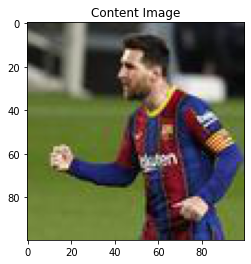

In [18]:
toPIL = transforms.ToPILImage()

def show_image(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
show_image(content_image, title='Content Image')

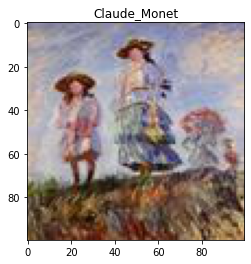

In [19]:
show_image(style_monet, title=Get_Artist(style_monet))

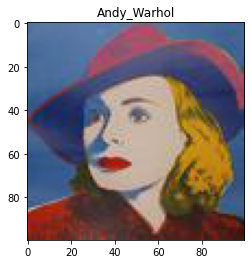

In [20]:
show_image(style_warhol, title=Get_Artist(style_warhol))

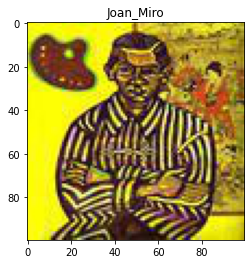

In [21]:
show_image(style_miro, title=Get_Artist(style_miro))

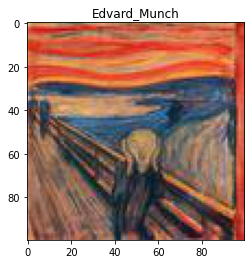

In [22]:
show_image(style_munch, title=Get_Artist(style_munch))

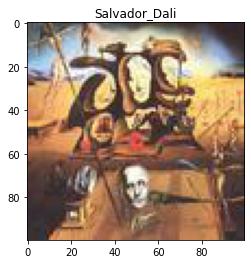

In [23]:
show_image(style_dali, title=Get_Artist(style_dali))

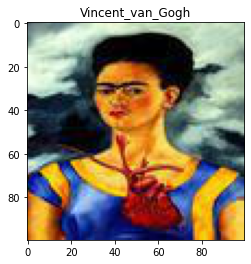

In [24]:
show_image(style_frida, title=Get_Artist(style_frida))

In [25]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  

    G = torch.mm(features, features.t())  

    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [26]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [27]:
content_layers_default = ['conv_2','conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_image, content_image,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [28]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [29]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_image, style_image, input_img, num_steps=500,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_image, content_image)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

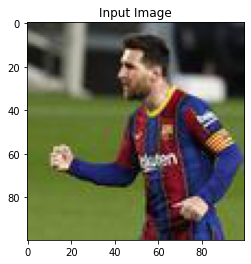

In [30]:
input_img = content_image.clone()

plt.figure()
show_image(input_img, title='Input Image')

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 79.104240 Content Loss: 31.619797

run [100]:
Style Loss : 37.424950 Content Loss: 30.321014

run [150]:
Style Loss : 24.413324 Content Loss: 28.595284

run [200]:
Style Loss : 17.530285 Content Loss: 27.284828

run [250]:
Style Loss : 13.699059 Content Loss: 26.432953

run [300]:
Style Loss : 11.516351 Content Loss: 25.816086

run [350]:
Style Loss : 10.172865 Content Loss: 25.386662

run [400]:
Style Loss : 9.407711 Content Loss: 25.176487

run [450]:
Style Loss : 8.834697 Content Loss: 24.859196

run [500]:
Style Loss : 8.483518 Content Loss: 24.622622



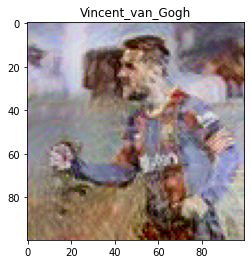

In [31]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_monet, input_img)

plt.figure()
show_image(output, title=Get_Artist(output))

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 147.698914 Content Loss: 34.561035

run [100]:
Style Loss : 63.845684 Content Loss: 35.394146

run [150]:
Style Loss : 40.854553 Content Loss: 34.719257

run [200]:
Style Loss : 30.135557 Content Loss: 34.018944

run [250]:
Style Loss : 23.724205 Content Loss: 33.526657

run [300]:
Style Loss : 19.751951 Content Loss: 32.856533

run [350]:
Style Loss : 17.527334 Content Loss: 32.190002

run [400]:
Style Loss : 16.291288 Content Loss: 31.625458

run [450]:
Style Loss : 15.419326 Content Loss: 31.190315

run [500]:
Style Loss : 14.842865 Content Loss: 30.876991



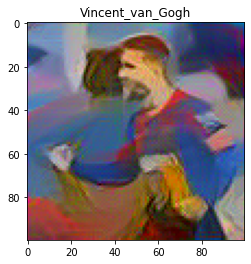

In [32]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_warhol, input_img)

plt.figure()
show_image(output, title=Get_Artist(output))

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 2874.272705 Content Loss: 153.695908

run [100]:
Style Loss : 582.730957 Content Loss: 152.954056

run [150]:
Style Loss : 262.945312 Content Loss: 151.261871

run [200]:
Style Loss : 158.199478 Content Loss: 148.921295

run [250]:
Style Loss : 113.009575 Content Loss: 146.224792

run [300]:
Style Loss : 90.109215 Content Loss: 143.997269

run [350]:
Style Loss : 76.277763 Content Loss: 142.207642

run [400]:
Style Loss : 70.424637 Content Loss: 140.550140

run [450]:
Style Loss : 70.172539 Content Loss: 138.886047

run [500]:
Style Loss : 67.223091 Content Loss: 137.520218



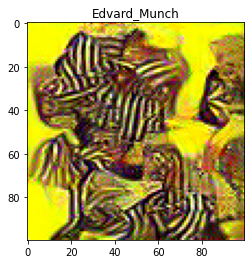

In [33]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_miro, input_img)

plt.figure()
show_image(output, title=Get_Artist(output))

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 235.285263 Content Loss: 84.141876

run [100]:
Style Loss : 71.206551 Content Loss: 79.370544

run [150]:
Style Loss : 37.489269 Content Loss: 74.908974

run [200]:
Style Loss : 26.217936 Content Loss: 70.568352

run [250]:
Style Loss : 21.060183 Content Loss: 66.619080

run [300]:
Style Loss : 17.999416 Content Loss: 63.390495

run [350]:
Style Loss : 16.259951 Content Loss: 60.725418

run [400]:
Style Loss : 15.070370 Content Loss: 58.493931

run [450]:
Style Loss : 14.174953 Content Loss: 56.674820

run [500]:
Style Loss : 13.418006 Content Loss: 55.242569



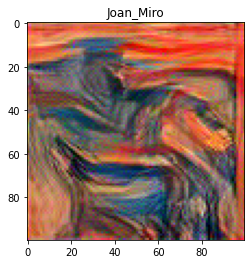

In [34]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_munch, input_img)

plt.figure()
show_image(output, title=Get_Artist(output))

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 151.633438 Content Loss: 59.224579

run [100]:
Style Loss : 59.167564 Content Loss: 55.864071

run [150]:
Style Loss : 35.750011 Content Loss: 52.214317

run [200]:
Style Loss : 27.371536 Content Loss: 49.154942

run [250]:
Style Loss : 23.019001 Content Loss: 46.918678

run [300]:
Style Loss : 20.654005 Content Loss: 44.989952

run [350]:
Style Loss : 18.926819 Content Loss: 43.425835

run [400]:
Style Loss : 18.007227 Content Loss: 42.217251

run [450]:
Style Loss : 17.404945 Content Loss: 41.183483

run [500]:
Style Loss : 16.676975 Content Loss: 40.326477



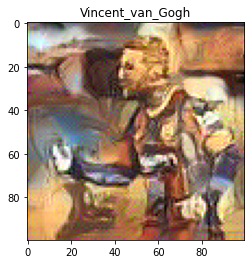

In [35]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_dali, input_img)

plt.figure()
show_image(output, title=Get_Artist(output))

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 550.263306 Content Loss: 60.329342

run [100]:
Style Loss : 228.364426 Content Loss: 63.184547

run [150]:
Style Loss : 142.263077 Content Loss: 64.289261

run [200]:
Style Loss : 105.797226 Content Loss: 64.797745

run [250]:
Style Loss : 83.776794 Content Loss: 65.000366

run [300]:
Style Loss : 72.105133 Content Loss: 64.749786

run [350]:
Style Loss : 63.610760 Content Loss: 64.383537

run [400]:
Style Loss : 60.679741 Content Loss: 64.325211

run [450]:
Style Loss : 53.232155 Content Loss: 64.083107

run [500]:
Style Loss : 68.877678 Content Loss: 64.371269



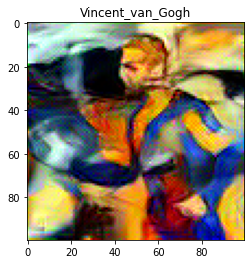

In [36]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_frida, input_img)

plt.figure()
show_image(output, title=Get_Artist(output))

plt.ioff()
plt.show()